In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
sns.set_style("whitegrid")
sns.set_palette("GnBu_d")
import folium
from folium import plugins
from folium.plugins import HeatMap
from datetime import datetime
from datetime import timedelta
import math
import random 
import timeit
from haversine import haversine
import sklearn as sk

In [3]:
brm = pd.read_csv("resources/bremen.csv")
frb = pd.read_csv("resources/freiburg.csv")
brm_hourly_driven = pd.read_csv("resources/brm_hourly_driven.csv")


In [4]:
brm_daily = brm.groupby("day").agg({"trip_duration":"sum","precipitation":"sum","temperature":"mean"})

SpecificationError: nested renamer is not supported

In [ ]:
brm_daily["trip_duration"] = brm_daily["trip_duration"].total_seconds()

In [179]:
x = brm_daily.values
x

array([[Timedelta('1 days 15:17:00'), 0.0, -1.837373737373737],
       [Timedelta('2 days 01:53:00'), 0.0, -2.236363636363639],
       [Timedelta('1 days 16:06:00'), 0.0, -1.6196531791907518],
       ...,
       [Timedelta('3 days 13:46:00'), 31.1, 4.328494623655909],
       [Timedelta('3 days 23:47:00'), 1.9000000000000008,
        4.431012658227851],
       [Timedelta('3 days 19:05:00'), 0.0, 4.93300733496333]],
      dtype=object)

In [178]:
x = brm_daily.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
demand = pd.DataFrame(x_scaled)

TypeError: float() argument must be a string or a number, not 'Timedelta'

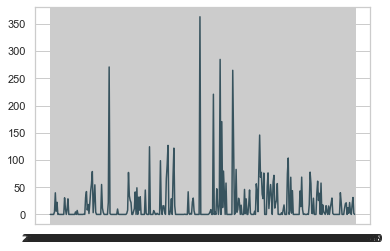

In [160]:
plt.plot(brm_daily["precipitation"])
plt.show()

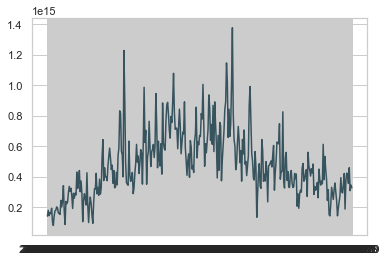

In [161]:
plt.plot(brm_daily["trip_duration"])
plt.show()

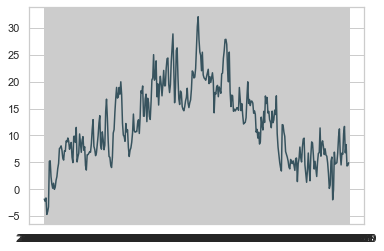

In [162]:
plt.plot(brm_daily["temperature"])
plt.show()